# 1. Dataset and metadata

The dataset(https://www.kaggle.com/dalpozz/creditcardfraud) contains transactions made by credit cards in September 2013 by European cardholders. The transactions all happened within 2 days, where there are 492 frauds out of 284, 807 transactions.(1)  
It’s in the format of .csv tabular data.
V1-V28 are the numerical principal components obtained through PCA transformation. Due to confidentiality issues, the original features and background information are not provided.
There are additional columns in the data that have the following information:
* Time:  The seconds elapsed between each transaction and the first transaction in the dataset;
* Amount: Transaction amount;
* Class: The classification class. 1: fraud; 0: legal transaction.

# 2. Exploratory Data Analysis (EDA)

In [20]:
#Capstone1: Credit Card Fraud
#1.Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from statsmodels.stats.weightstats import ztest
from scipy import stats

%matplotlib inline

In [2]:
#2.1 Import data
fn='creditcard.csv'
#Uncomment this in github fn='/Data/creditcard.csv'
df = pd.read_csv(fn)

First we want to get a general idea of what the dataset looks like, whether it has any missing values, the data format, the dimensions, simple summary stats and sample data in the beginning and at the end.

In [3]:
#2.2 Summary stats 
# Check missing data
df.isnull().any().sum() 

0

In [4]:
print(df.info())
print(df.shape)
print(df.columns)
print(df.describe())
print(df.head(5))
print(df.tail(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

We can see that, from initial exploratory analysis: None of the columns have missing data.
It has 284807 records in total, which is consistent with the description in the metadata. All of the features are numerical, with only ‘Class’ in the integer format, others being float. 
Further .shape attribute is used to confirm the dimensions: (284807, 31) and .columns attribute to confirm the column names. 
Finally, .describe(), .head() and .tail() methods are used to inspect summary stats, and general data structures of the beginning, and the end of the data frame respectively. From the above results, we can easily see that time is not unique for each entry, which means there are multiple transactions happening at the same time in the dataset. 

Next, we are plotting a heat map to see majorly the correlations of V1-V28. Since they were pre-processed by PCA, they are supposed to be a set of linearly uncorrelated variables. 

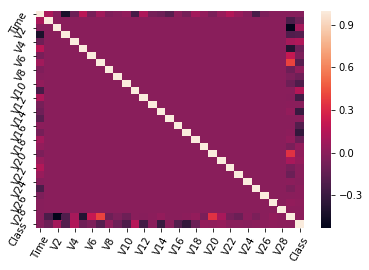

In [5]:
#Visualize correlations between all variables
sns.heatmap(df.corr())
plt.xticks(rotation=60)
plt.yticks(rotation=60)
plt.show()

The above graph confirms our previous assumption, as V1-V28 are completely uncorrelated (zero value, purple).

For the following sections, we are going to explore how these variables: PCA features, time, amount and class, distribute separately. 

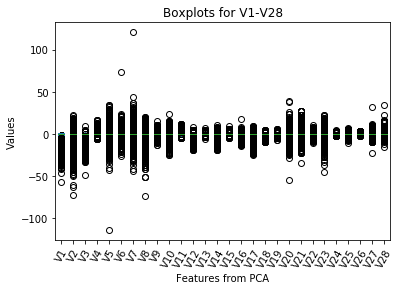

In [6]:
#By different categories: PCA features, Time, Amount, and Class(fraud or not)
#Visual EDA, PCA features plot
df_pca = df.iloc[:,1:29]
df_pca.plot(kind='Box')
plt.xticks(rotation=60)
plt.title('Boxplots for V1-V28')
plt.xlabel('Features from PCA')
plt.ylabel('Values')
plt.show()

We can see from the plot that in general, these 28 features are on the same scale of within -50 to 50. Several particularly noticeable outliers are in V5, V6, V7. Considering this is the box plot for all data including legal and fraud transactions, we will examine further later in the analysis to see where these outliers are from.

Next, we use .value_counts() on ‘Time’ column to confirm that Time is not unique, as the length reveals that there are only 124,592 unique values (as compared to 284, 807 total records). Further we are drawing a distribution plot to see whether there are any patterns in these transaction times.

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64
124592


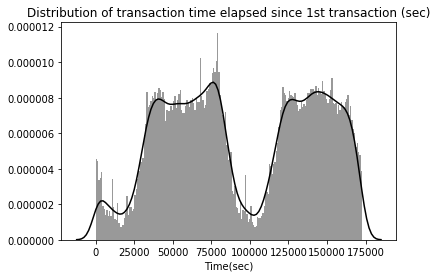

In [7]:
#EDA and visual EDA for time
print(df['Time'].describe())
print(len(df['Time'].value_counts())) 
plt.figure()
sns.distplot(df['Time'], bins = 200, norm_hist = True, color = 'black') 
plt.title('Distribution of transaction time elapsed since 1st transaction (sec)')
plt.xlabel('Time(sec)')
plt.show()

The plot shows us that there were certain time periods that transactions happened more frequently, considering this variable is expressed in seconds, we are creating a new column of datetime objects and another of hour for later analysis.

In [8]:
#Convert time into datetime obejct
def GetTime(time):
    sec = timedelta(seconds=time)
    d = datetime(1,1,1) + sec
    return d  
    #"%d:%d:%d:%d" % (d.day-1, d.hour, d.minute, d.second)      
df_newtime = [GetTime(time) for ind, time in df['Time'].iteritems()]
df['Newtime'] = df_newtime 
#Extract hour information
df['hour'] = [(GetTime(time)).hour for ind, time in df['Time'].iteritems()]

Next, we are using a boxplot to visualize the distribution of transaction amounts.

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


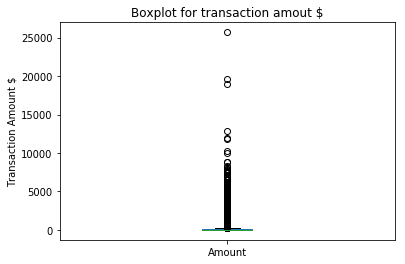

In [9]:
#EDA and visual EDA for amount 
print(df['Amount'].describe())
plt.figure()
df.plot(y='Amount', kind='box')
plt.title('Boxplot for transaction amout $')
plt.ylabel('Transaction Amount $')
plt.show()

We can see there are some outliers with really big values in this feature, and we’ll examine it further in the analysis.

For ‘Class’, since Class == 1 denotes the fraud transaction, we can use .sum() to confirm the total number of frauds within the dataset. As it turns out, there are 492 frauds in the whole dataset, which constitutes only 0.172% of all transactions, making it a very unbalanced dataset. 

In [10]:
#Class ==1:fraud. Confirm the number of frauds in the dataset.(Expected: Inbalanced)
fnum = df['Class'].sum()
fperc = float(fnum)/len(df['Class'])
print(fperc)

0.00172748563062


It will make sense to investigate all variables again separately based on the fraud/legal status, as they will certainly contain features that help distinguish a fraud transaction and a legal one. 

In [11]:
#2.3 EDA comparing fraud vs. legal transactions 
frauds=df[df['Class']==1]
legals=df[df['Class']==0]

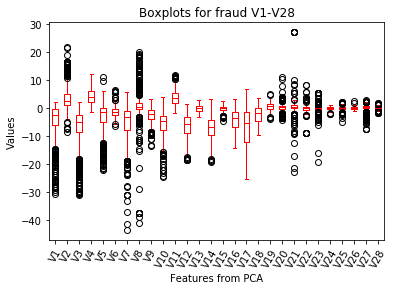

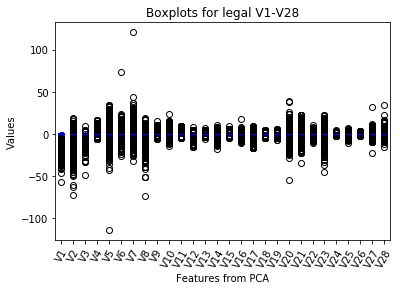

In [12]:
#V1-V28, boxplots for fraud and legal transactions 
frauds.iloc[:,1:29].plot(kind='Box', color = 'red')
plt.xticks(rotation=60)
plt.title('Boxplots for fraud V1-V28')
plt.xlabel('Features from PCA')
plt.ylabel('Values')
plt.show()
plt.savefig('Boxplots for fraud V1-V28.png')
legals.iloc[:,1:29].plot(kind='Box', color = 'blue')
plt.xticks(rotation=60)
plt.title('Boxplots for legal V1-V28')
plt.xlabel('Features from PCA')
plt.ylabel('Values')
plt.show()

As V1-V28 of fraud transactions show relatively (but not absolutely) more variations and therefore more dispersed winthin itself than legal transactions. However, as we can see here, the extremely big outliers that we spotted earlier in the whole dataset(V5, V6, V7) are actually from legal transactions.

Further, we are plotting each of the PCA features in an individual distribution plot to see visually how the feature differ between fraud and legal transactions, with red indicating ‘fraud’ and blue ‘legal’.

Index([u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9', u'V10',
       u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18', u'V19',
       u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27', u'V28'],
      dtype='object')


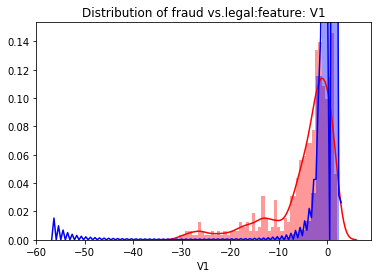

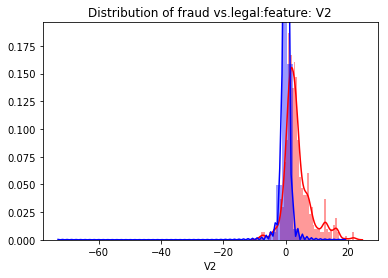

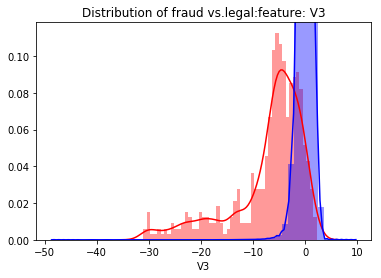

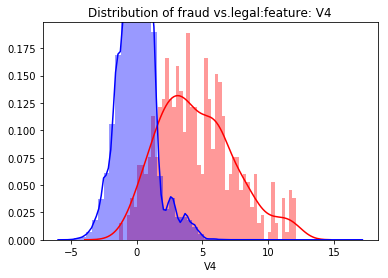

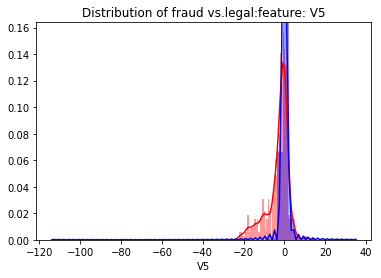

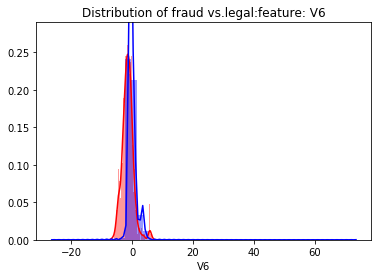

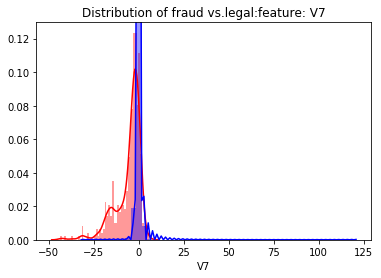

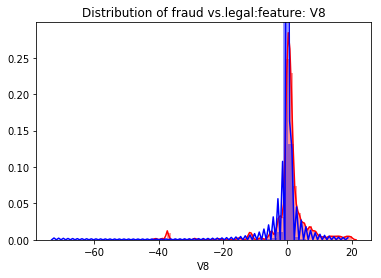

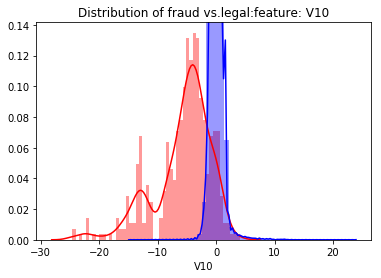

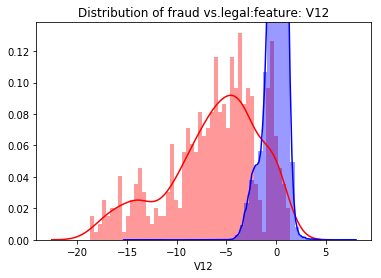

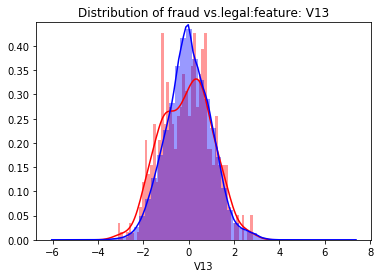

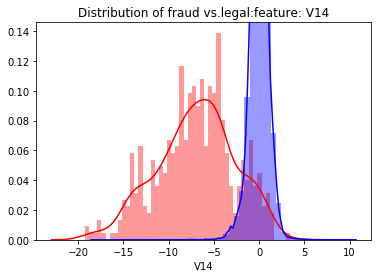

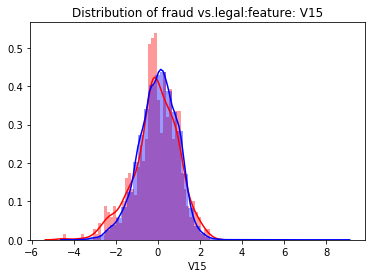

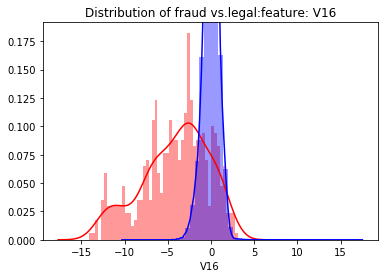

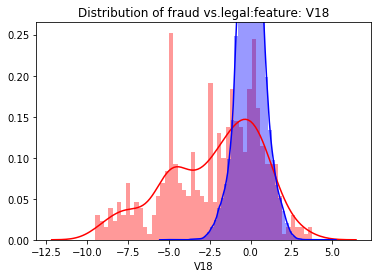

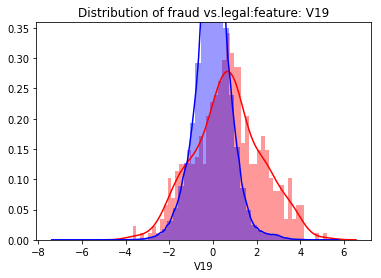

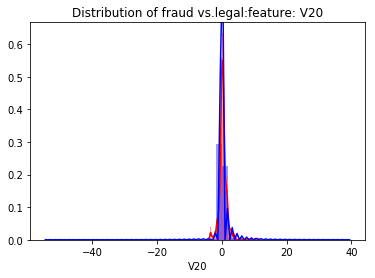

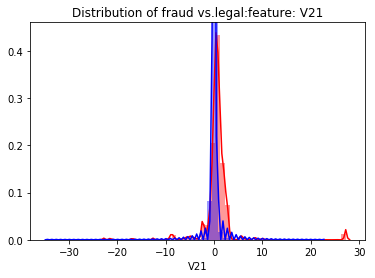

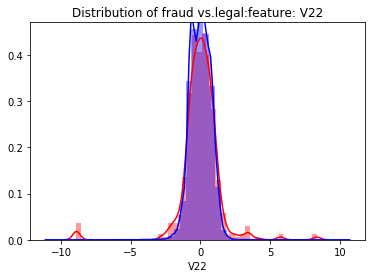

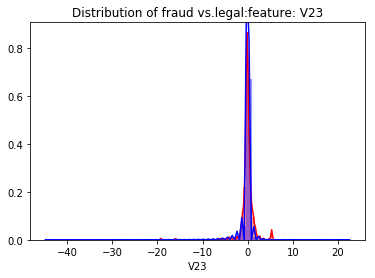

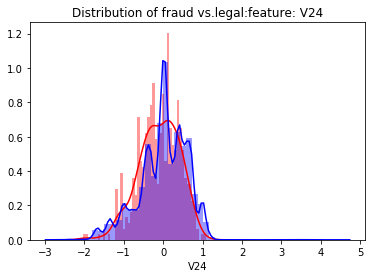

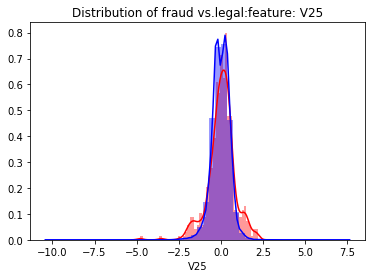

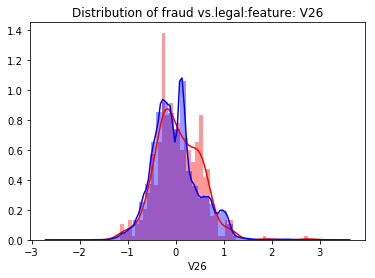

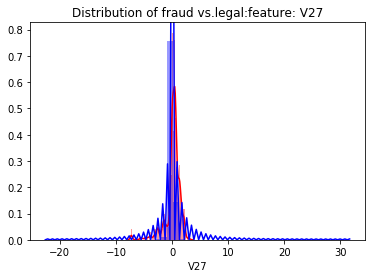

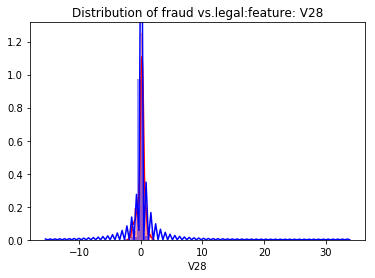

In [13]:
#Iterate through the 28 features and compare distibution for each fraud&legal pair
pca_names = df_pca.columns
print(pca_names)
for i, V in enumerate(df[pca_names]):
    plt.figure(i+1)
    sns.distplot(frauds[V], bins = 50, norm_hist = True, color = 'red')
    sns.distplot(legals[V], bins = 50, norm_hist = True, color = 'blue')
    plt.title('Distribution of fraud vs.legal:feature: ' + str(V))
    plt.show()
    plt.savefig(str(V)+'.png')
    plt.close()

These plots confirm our previous conclusion that, while legal transactions spread over a larger range in general, it has relatively much narrower peak range.

Transaction time histograms are also compared between fraud (red) and legal (blue) in original 'Time' variable, and  in 'hour' variable that we created earlier.

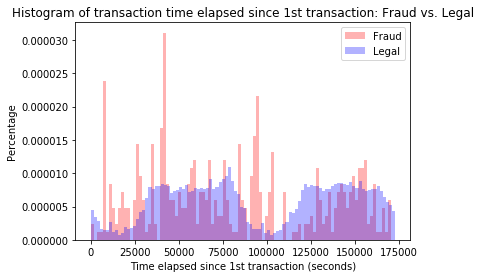

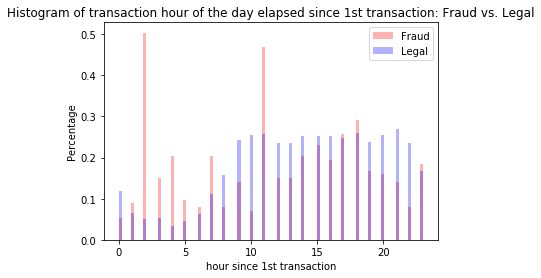

In [14]:
#Time, distribution plots for fraud vs. legal 
plt.figure()
frauds.Time.plot(kind='hist', bins=100, color = 'red', normed= True,label= 'Fraud', alpha = 0.3)
legals.Time.plot(kind='hist', bins=100, color = 'blue', normed= True, label= 'Legal',alpha = 0.3)
plt.legend(loc='upper right')
plt.title('Histogram of transaction time elapsed since 1st transaction: Fraud vs. Legal')
plt.xlabel('Time elapsed since 1st transaction (seconds)')
plt.ylabel('Percentage')
plt.show()
plt.savefig('Fraud vs. Legal Transaction Time.png')
#Check the hours 
plt.figure()
frauds.hour.plot(kind='hist', bins=100, color = 'red', normed= True,label= 'Fraud', alpha = 0.3)
legals.hour.plot(kind='hist', bins=100, color = 'blue', normed= True, label= 'Legal',alpha = 0.3)
plt.legend(loc='upper right')
plt.title('Histogram of transaction hour of the day elapsed since 1st transaction: Fraud vs. Legal')
plt.xlabel('hour since 1st transaction')
plt.ylabel('Percentage')
plt.show()

Both of the plots tell us that fraud transactions peak when the legal ones are low. We don’t have detailed time (24-hour clock) of the day of when the first transaction happened to calculate these transaction hours, but it would be logical to assume that these fraud transactions probably happen more frequently at late night and/or early morning when legal transactions are normally low.

Finally, we compare the transaction amounts for fraud and legal transactions in both .describe() function and a side by side graph.

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


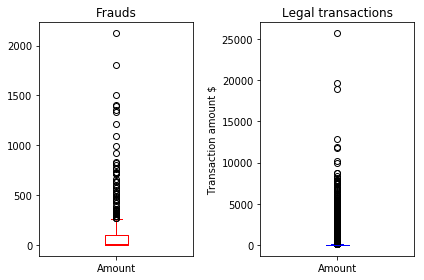

In [15]:
#Amount,summary stats and plots for fraud vs. legal 
print(frauds.Amount.describe())
print(legals.Amount.describe())
plt.figure()
plt.subplot(1,2,1)
frauds.Amount.plot(kind='Box',color = 'red')
plt.title('Frauds')
plt.subplot(1,2,2)
legals.Amount.plot(kind='Box',color = 'blue')
plt.title('Legal transactions')
plt.ylabel('Transaction amount $')
plt.tight_layout()
plt.show()

Fraud transactions are all much higher than zero (which is logical), and disperse throughout around 250 to 2000. Further, even though legal transactions have some extremely large values, the fraud transactions has a higher average (122 vs. 88) as can be obtained from the summary stats. 

Further, we can carry out hypothesis testing comparing statstics between fraud and legal transactions. The specific tests will be performed are:
* z-tests for V1-V28. The null hypothesis would be h0: fraud and legal transactions have the same mean PCA.
* K-S test for Time. The null hypothesis would be h0: fraud and legal time are from the same distribution.
* Bootstrap test for Amount. The null hypothesis would be h0: fraud and legal transactions have the same mean amount.

In [16]:
#2.4 Hypothesis testing
#z-test for V1-V28 features
#legal vs. fraud
#significant level 99%. Null Hypothesis: Vi fraud = Vi legal 
#any p< 0.10 will reject the null hypothesis 
for col in pca_names:
    p1 =  frauds[col]
    p0 = legals[col]
    z_cal, p_cal= ztest(x1=p1, x2=p0, value=0, alternative='two-sided', usevar='pooled', ddof=1)
    print(col,'statistically significant difference' if p_cal < 0.01 else 'statistically insignificant difference')

('V1', 'statistically significant difference')
('V2', 'statistically significant difference')
('V3', 'statistically significant difference')
('V4', 'statistically significant difference')
('V5', 'statistically significant difference')
('V6', 'statistically significant difference')
('V7', 'statistically significant difference')
('V8', 'statistically significant difference')
('V9', 'statistically significant difference')
('V10', 'statistically significant difference')
('V11', 'statistically significant difference')
('V12', 'statistically significant difference')
('V13', 'statistically insignificant difference')
('V14', 'statistically significant difference')
('V15', 'statistically insignificant difference')
('V16', 'statistically significant difference')
('V17', 'statistically significant difference')
('V18', 'statistically significant difference')
('V19', 'statistically significant difference')
('V20', 'statistically significant difference')
('V21', 'statistically significant difference

In [21]:
#K-S test for time(both Time and hour)
ks_cal1, p_cal1=stats.ks_2samp(frauds.Time, legals.Time)
print('K-S statistics for Time:', ks_cal1, 'p-value:',p_cal1)
ks_cal2, p_cal2=stats.ks_2samp(frauds.hour, legals.hour)
print('K-S statistics for hour:', ks_cal2, 'p-value:',p_cal2)

('K-S statistics for Time:', 0.16938909937434854, 'p-value:', 8.357813751103828e-13)
('K-S statistics for hour:', 0.1935411727716982, 'p-value:', 1.3815502491489748e-16)


For both (original) Time and hour, the p-values are small enough to reject the null hypothesis that the frauds and legals have the same distribution. The results are consistant with what we've obtained earlier using visual EDA.

We then carry out a bootstrap test for amount as well to see if the difference between frauds mean and legals mean is purely due to chance. Therefore our null hypothesis h0: the mean of fraud amount = legal amount.

In [18]:
#bootstrapping for Amount
#legal vs. fraud
#first define relevant functions:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D Data"""
    bs_sample = np.random.choice(data.values, len(data))

    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

('p-value =', '0.000000')


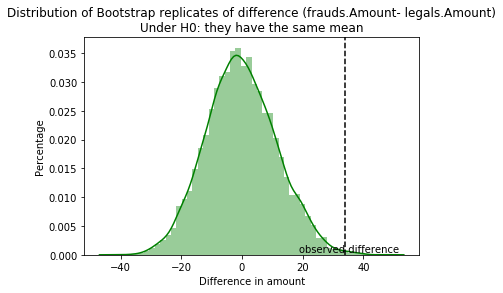

In [19]:
#Hypothesis testing: significant level alpha =0.01, Null Hypthesis: they have the same mean
mean_amount = np.mean(df.Amount.values)
obs_diff_mean = np.mean(frauds.Amount.values) - np.mean(legals.Amount.values)

frauds_shifted = frauds.Amount - np.mean(frauds.Amount.values) + mean_amount
legals_shifted = legals.Amount - np.mean(legals.Amount.values) + mean_amount

bs_replicates_frauds = draw_bs_reps(frauds_shifted, np.mean, 10000)
bs_replicates_legals = draw_bs_reps(legals_shifted, np.mean, 10000)

bs_replicates = bs_replicates_frauds - bs_replicates_legals

# Compute and print p-value: p
p = np.sum(bs_replicates >= obs_diff_mean) / len(bs_replicates)        #because obs_diff_mean= 33.92
print('p-value =', format(p, '.6f'))                                  

#visualize the bootstrap replicates results
sns.distplot(bs_replicates, bins = 50, norm_hist = True, color = 'green')
plt.axvline(x=obs_diff_mean, color='k', linestyle='--')
plt.text(obs_diff_mean-15, 0.0005, 'observed difference')
plt.xlabel('Difference in amount')
plt.ylabel('Percentage')
plt.title('Distribution of Bootstrap replicates of difference (frauds.Amount- legals.Amount)\nUnder H0: they have the same mean')
plt.show()

As we can see here, the difference in means of fraud transactions and legal transactions is highly unlikely due to chance, as p-value for getting a observed difference of ~33.92 or more extreme is 0.000000.

In summary, this dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, frauds (class ==1) only account for 0.172% of all transactions.
No missing value is present as concluded from EDA, and therefore there is no need for cleaning the data. Also considering the data was pre-processed by PCA to maintain confidentiality of sensitive information, I would assume all outliers, if any, are not completely meaningless. Depending on the models that I'll later build, I will decide on whether to remove them or not on a case-by-case basis. V1-V28, time(hour) and amount in general, demonstrate different stats properties in fraud and legal transactions, so it would be reasonable to include them in the prediction model. 

TO DO (based on readings)
Re-scale the features? 
Select optimum feature numbers for different models? Some drop the time, some don't.
Using metrics: precision, recall, f1-score, and ROC AUC 